In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np

class SOM:
    def __init__(self, width, height, dim):
        self.num_iters = 100
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()

        nodes = tf.Variable(tf.random_normal([width*height, dim]))
        self.nodes = nodes
        
        x = tf.placeholder(tf.float32, [dim])
        iter = tf.placeholder(tf.float32)
        
        self.x = x
        self.iter = iter
        
        bmu_loc = self.get_bmu_loc(x)
        
        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter)
        
    def get_propagation(self, bmu_loc, x, iter):
        num_nodes = self.width * self.height
        rate = 1.0 - tf.div(iter, self.num_iters)
        alpha = rate * 0.5
        sigma = rate * tf.to_float(tf.maximum(self.width, self.height)) / 2.
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0)
        sqr_dists_from_bmu = tf.reduce_sum(tf.square(tf.sub(expanded_bmu_loc, self.node_locs)), 1)
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma)))
        rate = tf.mul(alpha, neigh_factor)
        rate_factor = tf.pack([tf.tile(tf.slice(rate, [i], [1]), [self.dim]) for i in range(num_nodes)])
        nodes_diff = tf.mul(rate_factor, tf.sub(tf.pack([x for i in range(num_nodes)]), self.nodes))
        update_nodes = tf.add(self.nodes, nodes_diff)
        return tf.assign(self.nodes, update_nodes)
    
    def get_bmu_loc(self, x):
        expanded_x = tf.expand_dims(x, 0)
        sqr_diff = tf.square(tf.sub(expanded_x, self.nodes))
        dists = tf.reduce_sum(sqr_diff, 1)
        bmu_idx = tf.argmin(dists, 0)
        bmu_loc = tf.pack([tf.mod(bmu_idx, self.width), tf.div(bmu_idx, self.width)])
        return bmu_loc
    
    def get_locs(self):
        locs = [[x, y]
            for y in range(self.height)
            for x in range(self.width)]
        return tf.to_float(locs)
    
    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for i in range(self.num_iters):
                for data_x in data:
                    sess.run(self.propagate_nodes, feed_dict={self.x: data_x, self.iter: i})
            
            centroid_grid = [[] for i in range(self.width)]
            self.nodes_val = list(sess.run(self.nodes))
            self.locs_val = list(sess.run(self.node_locs))
            for i, l in enumerate(self.locs_val):
                centroid_grid[int(l[0])].append(self.nodes_val[i])
            
            self.centroid_grid = centroid_grid

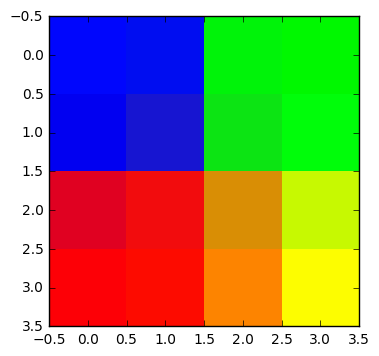

In [3]:
from matplotlib import pyplot as plt
import numpy as np
#from som import SOM

colors = np.array([
        [0., 0., 1.],
        [0., 0., 0.95],
        [0., 0.05, 1.],
        [0., 1., 0.],
        [0., 0.95, 0.],
        [0., 1, 0.05],
        [1., 0., 0.],
        [1., 0.05, 0.],
        [1., 0., 0.05],
        [1., 1., 0.]
])

som = SOM(4, 4, 3)
som.train(colors)

plt.imshow(som.centroid_grid, interpolation='none')
plt.show()